# 0.0. Mission

## Context

<p> Alpha Insurance is a company that provides health insurance to their customers. With the goal of improving <br> their revenue the product team is thinking about 
the possibility of offering car insurance to its customers.</p>

<p>The enterprise has made a research with over 380,000 customers to know their intention
in purchasing the new <br> service. The product team has selected another 127,000 customers
that the sales team will try to sell the new service. </p>
    
<p>As the sales team cannot get in touch with all of the selected customers during the campaign time,
they need to <br> give priority to those clients that are more likely to purchase the service. So 
they need a data scientist to select the <br> 20,000 more interested customers. </p>

## Challenge

<b>Select the 20,000 customers, that are more interested in buying the car insurance.</b>

# 1.0. Preparing Process

## 1.1. IMPORTS

In [1]:
import math
import datetime
import inflection
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display         import Image



###--------- PANDAS - EXIBIR TODAS COLUNAS ----###

pd.set_option('display.max_columns', None)


###--------- ESTILIZAÇÃO DO NOTEBOOK ---------###

from IPython.core.display import display, HTML

# retira a margem do notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

# font do texto markdown
display(HTML("<style>h1 { font-size:23px !important; }</style>"))
display(HTML("<style>h2 { font-size:20px !important; }</style>"))
display(HTML("<style>h3 { font-size:17px !important; }</style>"))
display(HTML("<style>h4 { font-size:16px !important; }</style>"))
display(HTML("<style>p { font-size:16px !important; }</style>"))

# tamanho da fonte da tabela
display(HTML("<style>th { font-size:15px !important; }</style>"))
display(HTML("<style>td { font-size:15px !important; }</style>"))

# font do codigo 
display(HTML("<style>span { font-size:16px !important; }</style>"))

## 1.2. Helper Functions

## 1.3. Loading Data

In [2]:
train_raw_data = pd.read_csv('data/train.csv', low_memory=False)
test_raw_data = pd.read_csv('data/test.csv', low_memory=False)

In [3]:
train_raw_data.sample()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
31912,31913,Male,38,1,28.0,1,1-2 Year,No,26314.0,26.0,16,0


# 2.0. Data Description

In [4]:
df2 = train_raw_data.copy()

## 2.1. Rename Columns

In [5]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
               'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
               'Policy_Sales_Channel', 'Vintage', 'Response']
cols_old

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [6]:
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df2.columns = cols_new

## 2.2. Data Dimension

In [7]:
print('The number of rows is: {}'.format( df2.shape[0] ))
print('The number of columns is: {}'.format( df2.shape[1] ))

The number of rows is: 381109
The number of columns is: 12


## 2.3. Data Types

In [8]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 2.4. Check NA

In [9]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.5. Change Types

In [10]:
# Check if can convert region_code from float to int
aux1 = np.array( df2['region_code'] )
aux2 = aux1.astype(int)
np.sum( aux1 - aux2 )

# Converting region_code from float to int
df2['region_code'] = df2['region_code'].astype(int)

### vehicle_age

vehicle_age is an object, we need to convert it to float. 
    
 It's necessary to assume numerical values for the:
3 options

< 1 Year  -->   0.5,  we assumed the mean value
    
1-2 Year  -->   1.5,  we assumed the mean value

\> 2 Year  -->   7.5, it's difficult to consider some mean value, so lets consider a number 5 times bigger than the previous


In [11]:
# Changing categories' names of vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'new' if x == '< 1 Year' else 'almost_new' if x =='1-2 Year' else 'old')

# Convert annual_premium from float to int
df2['annual_premium'] = df2['annual_premium'].astype(int)

# Convert policy_sales_channel from float to int
df2['policy_sales_channel'] = df2['policy_sales_channel'].astype(int)

# Convert vehicle_damage from object to int
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x=='No' else 1)

In [12]:
df2.dtypes

id                       int64
gender                  object
age                      int64
driving_license          int64
region_code              int64
previously_insured       int64
vehicle_age             object
vehicle_damage           int64
annual_premium           int64
policy_sales_channel     int64
vintage                  int64
response                 int64
dtype: object

## 2.6. Split data between Categorical and Numerical data

In [13]:
df2.sample()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
53166,53167,Female,23,1,21,0,new,1,2630,160,92,0


In [14]:
num_data = df2[['age', 'annual_premium', 'vintage']]
cat_data = df2[['gender', 'vehicle_age' ,'driving_license', 'region_code', 'previously_insured', 'vehicle_damage', 'policy_sales_channel']]

## 2.7. Descriptive Statistics

### Relevant metrics

In [15]:
num_mean = pd.DataFrame( num_data.apply( np.mean ) ).T
num_std = pd.DataFrame( num_data.apply( np.std ) ).T
num_median = pd.DataFrame( num_data.apply( np.median ) ).T
num_min = pd.DataFrame( num_data.apply( min ) ).T
num_max = pd.DataFrame( num_data.apply( max ) ).T
num_range = pd.DataFrame( num_data.apply( lambda x: x.max() - x.min() ) ).T
num_skew = pd.DataFrame( num_data.apply( lambda x: x.skew() ) ).T
num_kurtosis = pd.DataFrame( num_data.apply( lambda x: x.kurtosis() ) ).T

analysis_table = pd.concat( [num_mean, num_std, num_median, num_min, num_max, num_range, num_skew, num_kurtosis] ).T
analysis_table.columns = ['mean', 'std', 'median', 'min', 'max', 'range', 'skew', 'kurtosis']

In [16]:
analysis_table

,mean,std,median,min,max,range,skew,kurtosis
age,38.822584,15.511591,36.0,20.0,85.0,65.0,0.672539,-0.565655
annual_premium,30564.389581,17213.132474,31669.0,2630.0,540165.0,537535.0,1.766087,34.004569
vintage,154.347397,83.671194,154.0,10.0,299.0,289.0,0.003030,-1.200688


(1.0, 100000.0)

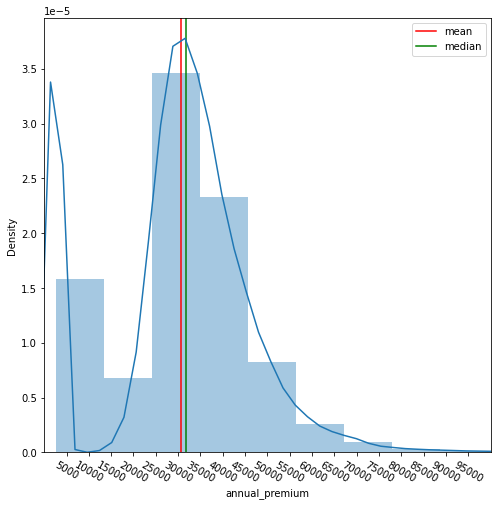

In [17]:
plt.figure(figsize=(8,8))
plt.xticks( np.arange(0, 100000, 5000), rotation=-30 )
plt.axvline(x=num_mean['annual_premium'][0], ymin=0, ymax=1, label='mean', color='r')
plt.axvline(x=num_median['annual_premium'][0], ymin=0, ymax=1, label='median', color='g')
plt.legend()
sns.distplot( df2['annual_premium'] ).set_xlim(1,100000)

In [18]:
# Amount of categories in each categorical variable
cat_data.apply( lambda x: x.unique().shape[0] )

gender                    2
vehicle_age               3
driving_license           2
region_code              53
previously_insured        2
vehicle_damage            2
policy_sales_channel    155
dtype: int64

#### Boxplots

Text(0.5, 1.0, 'Insurance acceptance of people who have never had a vehicle damage')

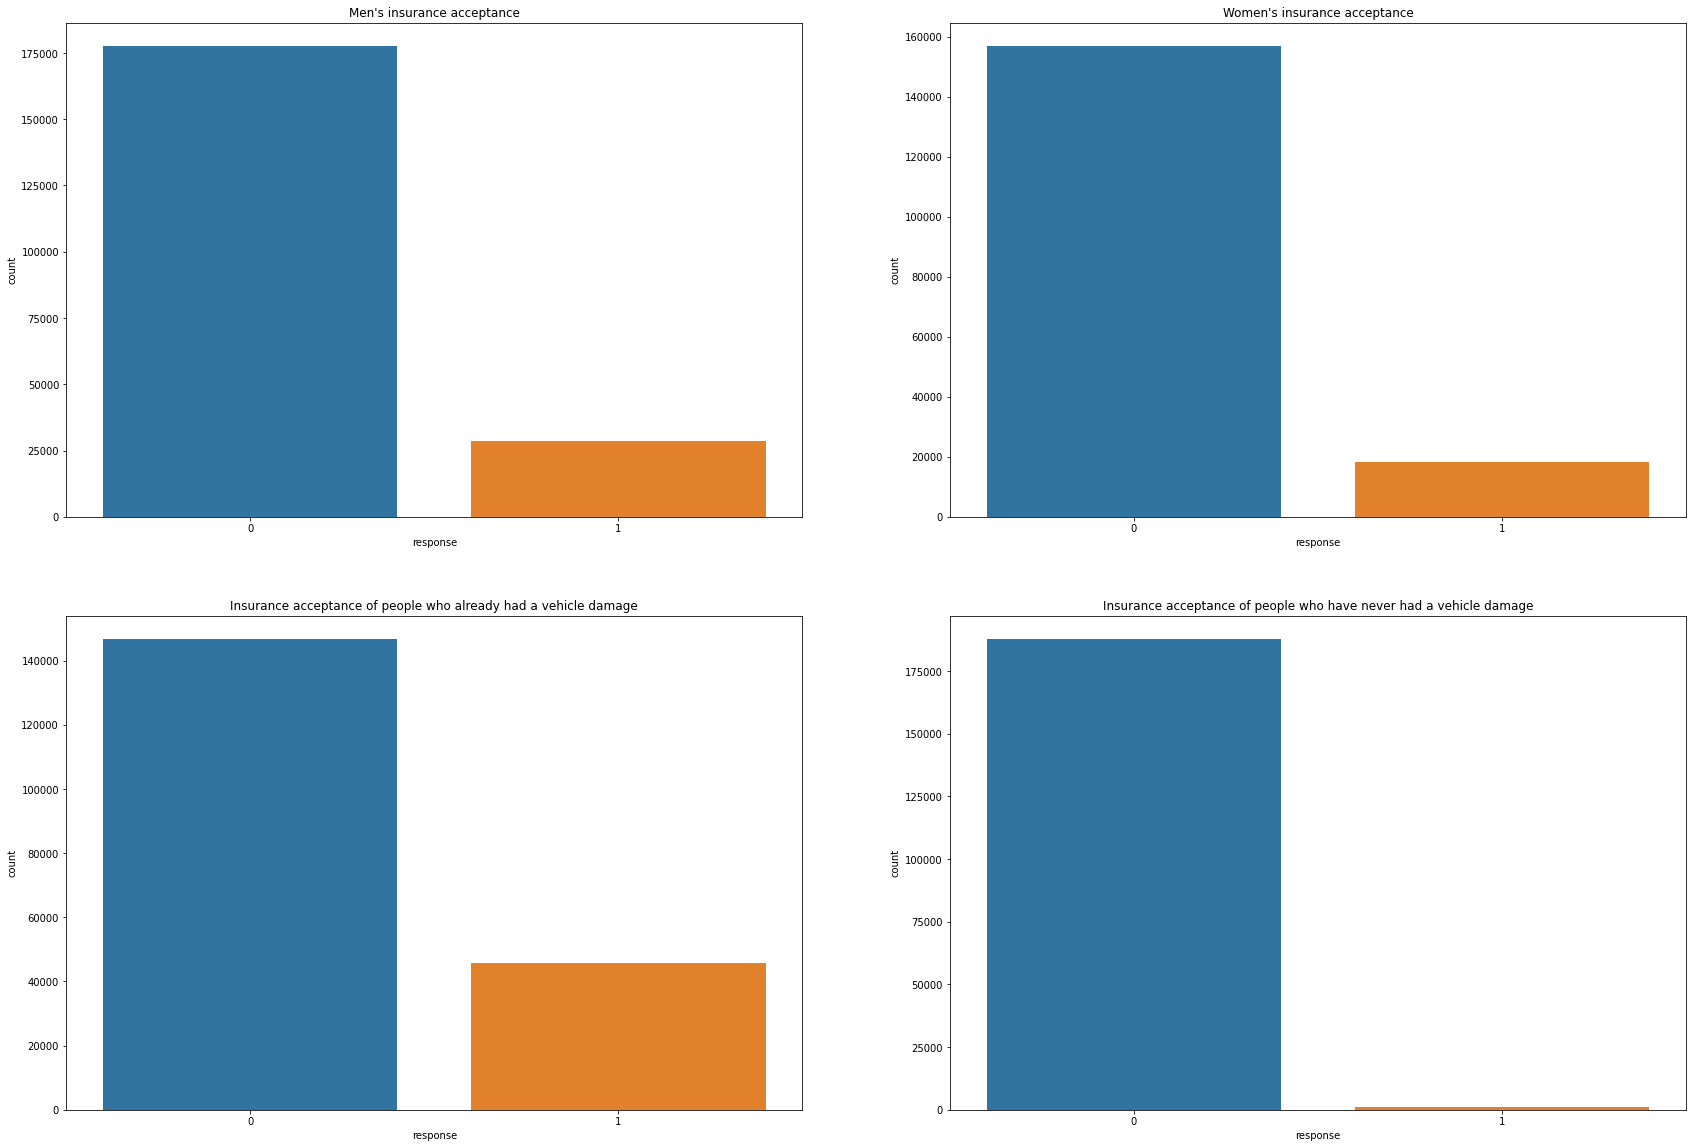

In [19]:
plt.figure(figsize=(12,20))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=None)

plt.subplot(2,2,1)
aux = df2[ df2['gender'] == 'Male' ]
sns.countplot( aux['response'] ).set_title('Men\'s insurance acceptance')

plt.subplot(2,2,2)
aux2 = df2[ df2['gender'] == 'Female' ]
sns.countplot( aux2['response'] ).set_title('Women\'s insurance acceptance')

plt.subplot(2,2,3)
aux3 = df2[ df2['vehicle_damage'] == 1 ]
sns.countplot( aux3['response'] ).set_title('Insurance acceptance of people who already had a vehicle damage')

plt.subplot(2,2,4)
aux4 = df2[ df2['vehicle_damage'] == 0 ]
sns.countplot( aux4['response'] ).set_title('Insurance acceptance of people who have never had a vehicle damage')


In [20]:
cat_data

,gender,vehicle_age,driving_license,region_code,previously_insured,vehicle_damage,policy_sales_channel
0,Male,old,1,28,0,1,26
1,Male,almost_new,1,3,0,0,26
2,Male,old,1,28,0,1,26
3,Male,new,1,11,1,0,152
4,Female,new,1,41,1,0,152
...,...,...,...,...,...,...,...
381104,Male,almost_new,1,26,1,0,26
381105,Male,new,1,37,1,0,152
381106,Male,new,1,30,1,0,160
381107,Female,old,1,14,0,1,124


# 3.0. Feature Engineering

In [21]:
df3 = df2.copy()

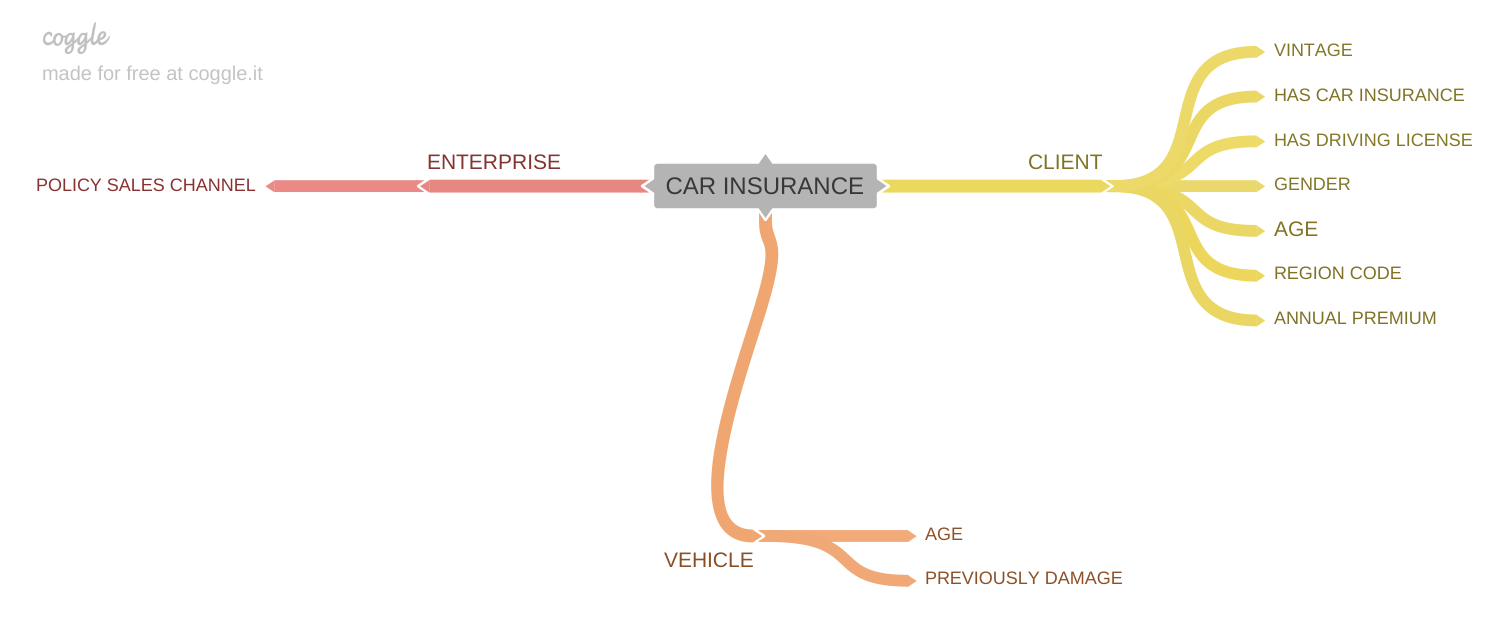

In [22]:
Image('img/CAR_INSURANCE_MIND_MAP.png')

## 3.1. Hypothesis creation

### 3.1.1. Hypothesis about the client

**1.** Clients with higher VINTAGE, have higher chances of accepting a new service from the company.

**2.** Clients that already have a car's insurance have lower chances of accepting another car's insurance.

**3.** Clients that have a driving license are more proned to accept a car's insurance, than those that dont have one.

**4.** Clients that are young have higher chances of purchasing a car's insurance.

**5.** Clients who live in dangerous areas are more proned to purchase a car's insurance.

**6.** Clients whose annual premium is expensive, tends to not purchase a car's insurance.

### 3.1.2. Hypothesis about the vehicle

**1.** Clients whose vehicle is new are more proned to purchase a car's insurance.

**2.** Clients whose vehicle has been already damaged, tends to purchase a car's insurance.

## 3.2. Final hypothesis list

Choose the hypothesis that the needed data are available for prediction.

**1.** Clients with higher VINTAGE, have higher chances of accepting a new service from the company.

**2.** Clients that already have a car's insurance have lower chances of accepting another car's insurance.

**3.** Clients that have a driving license are more proned to accept a car's insurance, than those that dont have one.

**4.** Clients that are young have higher chances of purchasing a car's insurance.

**5.** Clients who live in dangerous areas are more proned to purchase a car's insurance.

**6.** Clients whose annual premium is expensive, tends to not purchase a car's insurance.

**7.** Clients whose vehicle is new are more proned to purchase a car's insurance.

**8.** Clients whose vehicle has been already damaged, tends to purchase a car's insurance.

In [23]:
df3.sample()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
353214,353215,Female,21,1,13,0,almost_new,1,33799,157,58,0


## 3.3. Deriving New Variables

# 4.0. Exploratory Data Analysis

In [24]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='response', ylabel='count'>

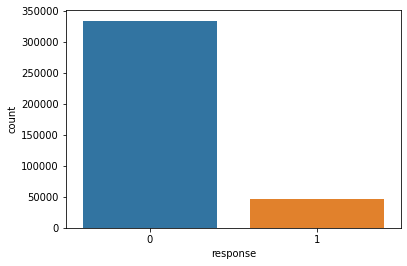

In [25]:
sns.countplot( df4['response'] )

### 4.1.2. Numerical Variables

<AxesSubplot:title={'center':'Distribution of vintage'}, xlabel='vintage', ylabel='Count'>

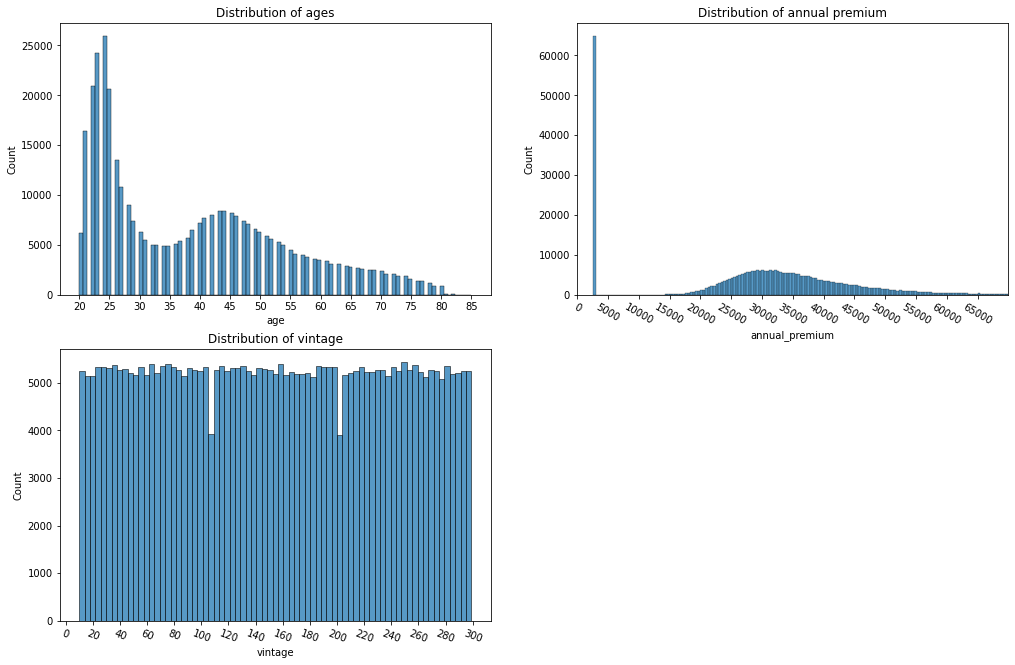

In [26]:
plt.figure(figsize=(17,11))
plt.subplot(2,2,1)
plt.title('Distribution of ages')
plt.xticks( np.arange(0, 100, 5), rotation=0 )
sns.histplot(df4['age'])

plt.subplot(2,2,2)
plt.title('Distribution of annual premium')
plt.xticks( np.arange(0, 70000, 5000), rotation=-30 )
plt.xlim(0,70000)  
sns.histplot(df4['annual_premium'])

plt.subplot(2,2,3)
plt.title('Distribution of vintage')
plt.xticks( np.arange(0, 320, 20), rotation=-20 )
sns.histplot(df4['vintage'])

### 4.1.3. Categorical Variables

In [27]:
cat_data.columns

Index(['gender', 'vehicle_age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_damage', 'policy_sales_channel'],
      dtype='object')

<AxesSubplot:title={'center':'Percentage of purchases intention in FEMALE GENDER'}>

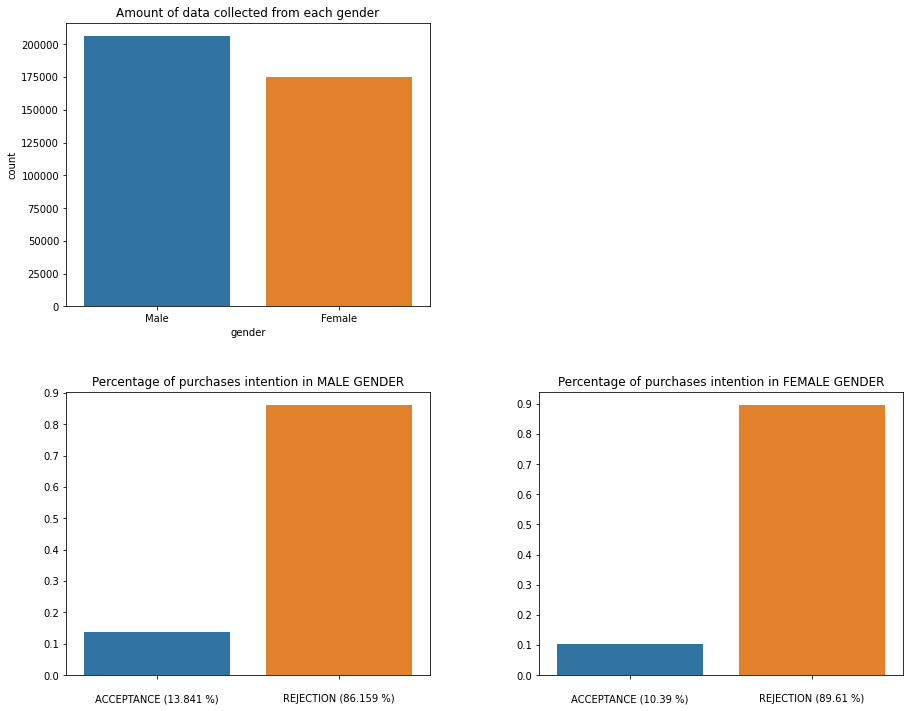

In [75]:
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

# Amount of data collected from each gender
plt.subplot(2,2,1)
plt.title('Amount of data collected from each gender')
sns.countplot(df4['gender'])


# Percentages of purchases intention in male gender
plt.subplot(2,2,3)
# Selecting just the gender male
df_male = df4[ df4['gender'] == 'Male' ]
male_num_accept = df_male[ df_male['response'] == 1 ].count()[0]
male_num_reject = df_male[ df_male['response'] == 0 ].count()[0]
male_accept_perc = (male_num_accept) / (male_num_accept + male_num_reject)

plt.title('Percentage of purchases intention in MALE GENDER')
plt.yticks( np.arange(0,1,0.1), rotation=0 )
sns.barplot( x=['\nACCEPTANCE ({} %)'.format( np.round ( 100 * male_accept_perc, 3 ) ),
                '\nREJECTION ({} %)'.format( np.round (100 * (1-male_accep_perc), 3 ) )],
             y=[male_accept_perc, (1-male_accept_perc)] )


# Percentage of purchases intention in female gender
plt.subplot(2,2,4)
# Selecting just the gender female
df_female = df4[ df4['gender'] == 'Female' ]
female_num_accept = df_female[ df_female['response'] == 1 ].count()[0]
female_num_reject = df_female[ df_female['response'] == 0 ].count()[0]
female_accept_perc = (female_num_accept) / (female_num_accept + female_num_reject)

plt.title('Percentage of purchases intention in FEMALE GENDER')
plt.yticks( np.arange(0,1,0.1), rotation=0 )
sns.barplot( x=['\nACCEPTANCE ({} %)'.format( np.round ( 100 * female_accept_perc, 3 ) ),
                '\nREJECTION ({} %)'.format( np.round (100 * (1-female_accept_perc), 3 ) )],
             y=[female_accept_perc, (1-female_accept_perc)] )


<AxesSubplot:>

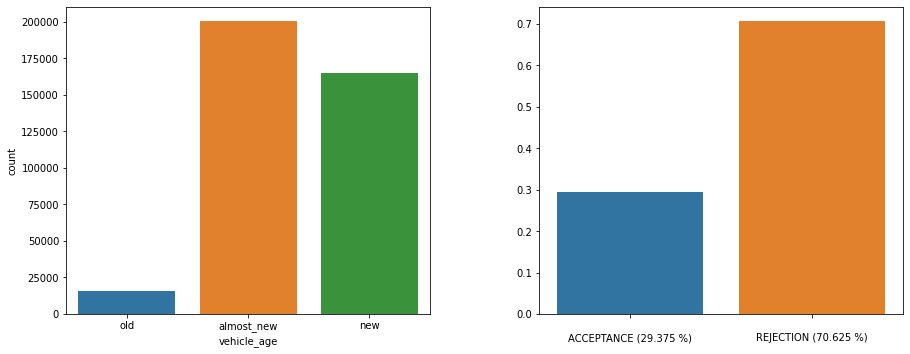

In [76]:
plt.figure(figsize=(15,13))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

# Amount of data collected from each vehicle age
plt.subplot(2,3,1)
# vehicle_age
sns.countplot( df4['vehicle_age'] )

# old cars
old_num_accept = df4[ (df4['vehicle_age'] == 'old') & (df4['response'] == 1) ].count()[0]
old_num_reject = df4[ (df4['vehicle_age'] == 'old') & (df4['response'] == 0) ].count()[0]
old_accept_perc = (old_num_accept) / (old_num_accept + old_num_reject)

plt.subplot(2,3,2)
sns.barplot( x=['\nACCEPTANCE ({} %)'.format( np.round ( 100 * old_accept_perc, 3 ) ),
                '\nREJECTION ({} %)'.format( np.round (100 * (1-old_accept_perc), 3 ) )],
             y=[old_accept_perc, (1-old_accept_perc)] )

# almost_new carsf
almost_new_num_accept = df4[ (df4['vehicle_age'] == 'almost_new') & (df4['response'] == 1) ].count()[0]
almost_new_reject = df4[ (df4['vehicle_age'] == 'almost_new') & (df4['response'] == 0) ].count()[0]
old_accept_perc = (old_num_accept) / (old_num_accept + old_num_reject)

plt.subplot(2,3,2)
sns.barplot( x=['\nACCEPTANCE ({} %)'.format( np.round ( 100 * old_accept_perc, 3 ) ),
                '\nREJECTION ({} %)'.format( np.round (100 * (1-old_accept_perc), 3 ) )],
             y=[old_accept_perc, (1-old_accept_perc)] )

# new cars
new_num_accept = df4[ (df4['vehicle_age'] == 'new') & (df4['response'] == 1) ].count()[0]
new_num_reject = df4[ (df4['vehicle_age'] == 'new') & (df4['response'] == 0) ].count()[0]



In [54]:
df4.sample()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
318785,318786,Male,65,1,28,0,old,1,44279,122,85,1
